# Trabajo Práctico 1

##Grupo: Amestoy - D'Ascanio

## Preparación

In [ ]:
%matplotlib inline

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Funciones básicas

In [ ]:
#Función básica de entrenamiento

#net: red que se debe entrnar
#epochs: cantidad de epochs
#trainloader: trainloader que generará el juego de entrenamiento
#quiet: True para mostrar únicamente la pérdida registrada en la última epoch, False para mostrar las pérdidas cada 100 steps
#plot: True para graficar la evolución de la pérdida en función de los pasos
#early_stop: True para implementar early stopping
def train(net, epochs, trainloader, quiet=False, plot=False, early_stop=False):

    def graph(plt_data):
      fig, ax = plt.subplots(figsize=(8,4))
      ax.set_xlabel('step')
      ax.set_ylabel('loss')
      ax.set_title('Rolling average loss'.format(epoch))
      ax.plot(pd.Series(plt_data).rolling(100).mean())
  
    total_step = len(trainloader)
    net.train()

    loss_plt = []
    plt_data = []
    loss_ser = []
    last_loss = 100
    thres = 2
    trigger_times = 0

    for epoch in range(epochs):  # loop over the dataset multiple time
        running_loss = 0.0
        epoch_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            if i == 0:
              start = time.time()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if device != 'cpu':
              inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()
            plt_data.append(loss.item())

            if not quiet and i % 100 == 99:    # print every 100 mini-batches
                stop = time.time()
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, ETA: {:.4f}' 
                    .format(epoch + 1, epochs, i + 1, total_step, 
                            running_loss / 100, stop - start))
                loss_plt.append(running_loss / 100)
                running_loss = 0.0
                start = time.time()
        if early_stop:
          # Early stopping
          curr_loss = validate(net)
          loss_ser.append(curr_loss)
          print('Current loss: {:6f}'.format(curr_loss))

          if curr_loss > last_loss:
            best = last_loss
            trigger_times += 1
            print('Trigger times: {}\n'.format(trigger_times))

            if trigger_times >= thres:
              print('Early stopping! Epoch: {}'.format(epoch+1))
              fig, ax1 = plt.subplots(figsize=(10,5))
              ax1.plot(range(1,epoch+2),loss_ser)
              plt.xticks(range(1,epoch+2))              
              ax1.set_ylabel('Loss')
              ax1.set_xlabel('Epoch')
              ax1.set_title('Validation loss')
              ax1.axvline(x=epoch+1, ls='--')

              return

          else:
              print('trigger times: 0\n')
              trigger_times = 0

          last_loss = curr_loss

    if plot: graph(plt_data)
      

    print('Finished Training, last epoch mean loss {:.4f}'.format(epoch_loss / total_step))

In [ ]:
# Función básica para calcular la precisión

#testloader: loader que generará los casos de test
#classes: clases que serán utilizadas en el test
def calc_accuracy(testloader, classes):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          if device != 'cpu':
            images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network 
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
    # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data    
          if device != 'cpu':
            images, labels = images.to(device), labels.to(device)
          outputs = net(images.to(device))    
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

    
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                    accuracy))


In [ ]:
# Función básica para mostrar imágenes

def imshow(img):
      img = img / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

# Función básica para crear los loaders

#batch_size: Cantidad de batches, default 16
#grayscale: Si se deben convertir las imágenes a 1 canal (escala de grises), default False
def get_loaders(batch_size=16, grayscale=False):
  transforms_list = [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                
  ]

  if (grayscale):
    transforms_list.append(transforms.Grayscale())

  transform = transforms.Compose(transforms_list)

  CIFAR10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)

  CIFAR10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

  # Selecciono las primeras 3 clases

  idx = torch.tensor(CIFAR10_train.targets) == 0
  idx += torch.tensor(CIFAR10_train.targets) == 1
  idx += torch.tensor(CIFAR10_train.targets) == 2
  trainset = torch.utils.data.dataset.Subset(CIFAR10_train, np.where(idx==1)[0])

  idx = torch.tensor(CIFAR10_test.targets) == 0
  idx += torch.tensor(CIFAR10_test.targets) == 1
  idx += torch.tensor(CIFAR10_test.targets) == 2
  testset = torch.utils.data.dataset.Subset(CIFAR10_test, np.where(idx==1)[0])

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  classes = trainset.dataset.classes[:3]

  # get some random training images
  dataiter = iter(trainloader)
  images, labels = dataiter.next()

  # show images
  imshow(torchvision.utils.make_grid(images))
  # print labels
  print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

  return trainset, trainloader, testloader, classes, labels

#### Red neuronal inicial (de cnn.ipynb) para referencia

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

net = Net().to(device)

## Ejercicio 1: Hiperparámetros

### Punto A

Modificar la cantidad de canales (filtros) de la capa convolucional, el tamaño del
kernel (filtro) y el tamaño del kernel de la capa de max pooling de modo tal que la
red siga funcionando. Explicar la relación entre estas dimensiones entre sí y también
la relación con el tamaño de la entrada de la capa lineal.

#### Cambios en canales y tamaño de kernels

Probamos cambiando a 1 canal de entrada (escala de grises)

Files already downloaded and verified
Files already downloaded and verified


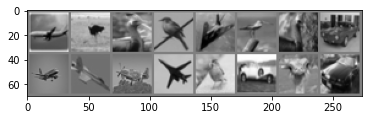

airplane  bird  bird  bird airplane  bird  bird automobile airplane airplane airplane airplane  bird automobile  bird automobile


In [ ]:
_, trainloader, testloader, classes, labels = get_loaders(grayscale=True)

#### Nueva red con modificaciones

Se realizaron los siguientes cambios:

- Cantidad de canales: se cambió a 1
- Tamaño del kernel (filtro): se cambió a 3x3
- Tamaño del kernel (max pooling): se probaron distintos valores, tales como 2x2, 3x3 y 5x5. El mejor resultado se obtuvo con 3x3.

En cuanto a la relación entre los valores, el *tamaño del kernel para el filtro* define el tamaño de la salida de la convolución. Las imágenes de CIFAR10 tienen un tamaño de 32x32 pixels. Un kernel de 3x3, para poder ocupar de manera completa una región de la imagen, debe descartar las 2 primeras filas y columnas (si no se utiliza padding, como en este caso). Por lo tanto, se genera a la salida del filtro una imagen de 30x30. En general, si el filtro es de *kxk*, la imagen luego de la convolución será de *(n - k + 1)x(n - k + 1)*

Luego, el tamaño del kernel de max pooling reduce el tamaño individual de cada imagen aún más, de manera proporcional. Así, siguiendo el ejemplo anterior, una imagen de 30x30 con un kernel de max pooling de 2x2 quedará reducida a 15x15, y a 10x10 con un kernel de 3x3.

En el cálculo de la entrada a Linear(), se toman:

- El valor de los canales de salida de la convolución, multiplicado por
- El ancho y el alto de cada imagen generada por el max pooling

Si tenemos, como en nuestro cálculo, 6 canales de salida de Conv2d() e imágenes de 10x10, el tamaño de entrada a Linear() será:

*6 canales x 10 pixels de ancho x 10 pixels de alto = 600 features de entrada*

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(6 * 10 * 10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.7509


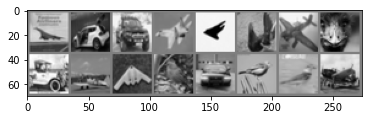

GroundTruth:  airplane , automobile , automobile , airplane , airplane ,  bird , airplane ,  bird , automobile , airplane , airplane ,  bird , automobile ,  bird ,  bird , airplane
Predicted:  airplane , airplane , automobile , airplane , airplane , automobile ,  bird , automobile , automobile , airplane , automobile ,  bird , automobile , airplane , airplane , airplane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' , '.join('%5s' % classes[labels[j]] for j in range(len(images))))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' , '.join('%5s' % classes[predicted[j]]
                              for j in range(len(images))))

In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 69 %
Accuracy for class airplane is: 65.4 %
Accuracy for class automobile is: 77.9 %
Accuracy for class bird  is: 64.4 %


Ahora probamos los siguientes cambios

- Cantidad de canales de entrada: se mantiene en 1
- Cantidad de canales de salida: se cambia a 12 (el doble que antes)
- Tamaño del kernel (filtro): se cambia a 6x6
- Tamaño del kernel (max pooling): se cambia a 4x4.

El objetivo es tener más imágenes a la salida (por el aumento de los canales), con un tamaño menor al anterior (por el aumento del filtro). El interés es lograr capturar más características de la imagen de entrada reduciendo el tamaño para poder concentrarse en aquellas características que sean más relevantes.
En este caso, el tamaño de entrada a Linear se obtiene del siguiente cálculo:

- Entrada a Conv2d(): 1x32x32
- Salida de Conv2d(): 12x27x27 (32 - 6 + 1 en ancho y alto)
- Salida de MaxPool2d(): 12x6x6 (27 div 4 en ancho y alto)

Por lo tanto, en Linear() tendremos:

*12 canales x 6 pixels de ancho x 6 pixels de alto = 432 features de entrada*

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 6)
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(12 * 6 * 6, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.6779


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 73 %
Accuracy for class airplane is: 63.1 %
Accuracy for class automobile is: 79.3 %
Accuracy for class bird  is: 77.9 %


En distintas corridas, la precisión de esta red fue similar o mejor a la red anterior.

### Punto B

Incorporar padding y stride distintos a los valores por defecto. Explicar en qué consisten.

#### Modificación de la red para incorporar padding y stride

Mediante el *padding* se agregan *k* filas y columnas con valores en 0 a la imagen de entrada. De esta manera, se pueden incluir en los cálculos los valores del margen de la imagen (que son descartados, si no hay padding, al aplicar el kernel), y la imagen resultante puede recuperar el tamaño de la imagen original (o superarlo, si se agrega más padding sobre lo perdido por la aplicación del kernel). Si se agrega más padding de lo necesario, se empiezan a tomar celdas que no formaban parte de la imagen original para hacer los cálculos.

El *stride* es el "paso" que da el kernel cuando se mueve sobre la imagen. Puede ser distinto a nivel horizontal y vertical. Un valor de 1 (default) es lo mismo que ir deslizando el kernel de a una columna y fila por vez. Si aumentamos ese número, el kernel "saltará" el valor que hayamos dado para volver a calcular, reduciendo el tamaño de la imagen de salida. Como se realiza un downsampling, podría quitarse la capa de de max pooling que se hace a continuación.

Para nuestro ejemplo, probamos lo siguiente:

* si en padding indicamos 'same', se recuperará un tamaño de imagen de salida de 32x32 (porque la de entrada crece a 34x34 y un kernel de 3x3 descartará 2 filas y columnas), pero no se permitirá un valor de *stride* distinto a 1 ([documentación de Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Si dejamos la capa de max pooling, con 3x3, se vuelven a reducir en 2 las dimensiones a 30x30. Con esta modificación la precisión estuvo alrededor del 72%.
* con padding=2, indicamos que agregue 2 filas y columnas (igual que con 'same'), pero sí se permite modificar el stride. Probamos con stride=2 y obtuvimos una precisión del 60%. Luego, quitamos la capa de max pooling y obtuvimos un 61%, siempre manteniendo la cantidad de epochs de entrenamiento en 10.

**Con padding='same'**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding='same')
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(6 * 10 * 10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.6858


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 72 %
Accuracy for class airplane is: 60.7 %
Accuracy for class automobile is: 81.8 %
Accuracy for class bird  is: 75.9 %


**Con padding=2, stride=2 y max pooling**

Es necesario ajustar las features de Linear() para reflejar que ahora tenemos

* 34x34 / 2 (stride) = 17x17
* kernel de 3x3 en capa de max pooling 17 div 3 = 5

Serán entonces 6 canales de salida x 5 x 5 = 150 features

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=2, stride=2)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(6 * 5 * 5, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.8698


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 61 %
Accuracy for class airplane is: 59.2 %
Accuracy for class automobile is: 79.7 %
Accuracy for class bird  is: 45.5 %


**Con padding=2, stride=2 SIN max pooling**

Al desaparecer la capa de max pooling, tenemos:

* 34x34 / 2 (stride) = 17x17

Serán entonces 6 canales de salida x 17 x 17

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=2, stride=2)
        self.fc1 = nn.Linear(6 * 17 * 17, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.7415


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 67 %
Accuracy for class airplane is: 62.0 %
Accuracy for class automobile is: 80.4 %
Accuracy for class bird  is: 60.0 %


Tanto el aumento del stride como la remoción de la capa de max pooling no mejoraron en nuestras pruebas la precisión de la red.

### Punto C

Dibujar la curva de la función costo en función de los pasos de entrenamiento. Variar el valor de la constante de aprendizaje y comentar si se observan diferencias en el comportamiento de la curva.

Se utilizará la red original de cnn.ipynb, y se graficará, además de la curva de costo, el rolling average de 100 steps, para suavizar las variaciones.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


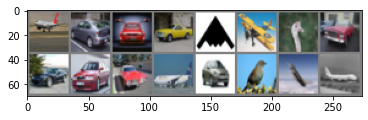

airplane automobile automobile automobile airplane airplane  bird automobile automobile automobile automobile airplane automobile  bird airplane airplane


In [ ]:
_, trainloader, testloader, _, _ = get_loaders()

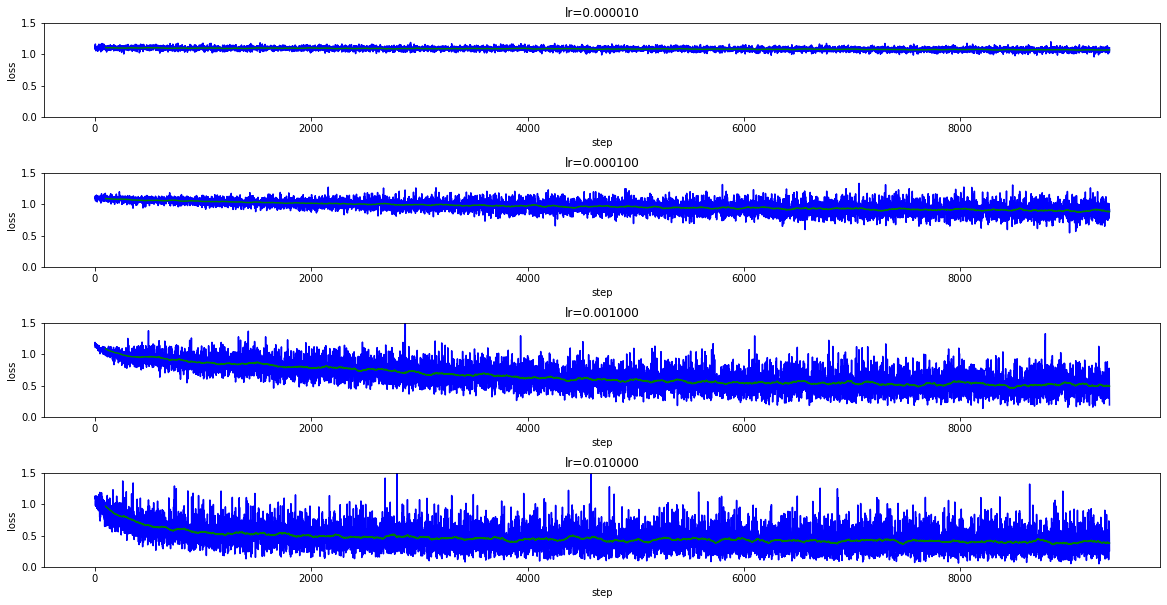

In [ ]:
n_epochs = 10

lrs = [0.00001, 0.0001, 0.001, 0.01]

fig, ax = plt.subplots(len(lrs), figsize=(20,10))
plt.subplots_adjust(hspace=0.6)

for lr_ndx, curr_lr in enumerate(lrs, 0):
    curr_ax = ax[lr_ndx]
    
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=curr_lr)
    
    total_step = len(trainloader)
    plt_data = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if device != 'cpu':
              inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            plt_data.append(loss.item())

    curr_ax.set_title('lr={:f}'.format(curr_lr))
    curr_ax.set_xlabel('step')
    curr_ax.set_ylabel('loss')
    curr_ax.set_ylim([0,1.5])
    curr_ax.plot(plt_data, 'b');
    curr_ax.plot(pd.Series(plt_data).rolling(100).mean(), 'g')

Se observa que learning rates muy chicos (1e-5 y 1e-4) provocan menos variaciones en el costo, pero tardan mucho en aprender. En cambio, los learning rates 0.001 y 0.01, si bien tienen más variación porque son más sensibles a las correcciones, provocan una disminución de costo más visible, sobre todo si se observa el rolling average.

### Punto D

Cambiar el parámetro batch_size y explicar por qué varía la cantidad de pasos en el entrenamiento al modificar este parámetro

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


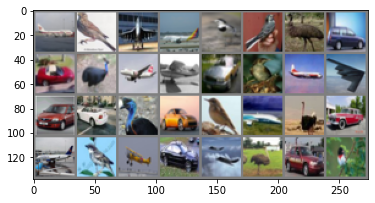

airplane  bird airplane airplane  bird  bird  bird automobile automobile  bird airplane airplane automobile  bird airplane airplane automobile automobile  bird automobile  bird airplane  bird automobile airplane  bird airplane automobile airplane  bird automobile  bird


In [ ]:
_, trainloader, testloader, _, _ = get_loaders(batch_size=32)

In [ ]:
import time

n_epochs = 10
total_step = len(trainloader)

loss_plt = []

for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i == 0:
          start = time.time()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if device != 'cpu':
          inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            stop = time.time()
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, ETA: {:.4f}' 
                .format(epoch + 1, n_epochs, i + 1, total_step, 
                        running_loss / 100, stop - start))
            loss_plt.append(running_loss / 100)
            running_loss = 0.0
            start = time.time()

print('Finished Training')

Epoch [1/10], Step [100/469], Loss: 0.3816, ETA: 0.9735
Epoch [1/10], Step [200/469], Loss: 0.3636, ETA: 0.9788
Epoch [1/10], Step [300/469], Loss: 0.3634, ETA: 1.1142
Epoch [1/10], Step [400/469], Loss: 0.3860, ETA: 1.1019
Epoch [2/10], Step [100/469], Loss: 0.3640, ETA: 1.0045
Epoch [2/10], Step [200/469], Loss: 0.3654, ETA: 1.0113
Epoch [2/10], Step [300/469], Loss: 0.3633, ETA: 1.1240
Epoch [2/10], Step [400/469], Loss: 0.3751, ETA: 0.9688
Epoch [3/10], Step [100/469], Loss: 0.3692, ETA: 0.9758
Epoch [3/10], Step [200/469], Loss: 0.3541, ETA: 0.9869
Epoch [3/10], Step [300/469], Loss: 0.3624, ETA: 1.0601
Epoch [3/10], Step [400/469], Loss: 0.3748, ETA: 0.9676
Epoch [4/10], Step [100/469], Loss: 0.3649, ETA: 1.0173
Epoch [4/10], Step [200/469], Loss: 0.3813, ETA: 0.9106
Epoch [4/10], Step [300/469], Loss: 0.3529, ETA: 0.9738
Epoch [4/10], Step [400/469], Loss: 0.3465, ETA: 0.9797
Epoch [5/10], Step [100/469], Loss: 0.3687, ETA: 0.8984
Epoch [5/10], Step [200/469], Loss: 0.3571, ETA:

Si aumentamos el tamaño de cada batch, la cantidad de pasos se reduce porque, por cada uno, se procesan más imágenes. Si tuvieramos un batch size de 1, cada paso utilizaría 1 imagen, y por lo tanto, tendríamos tantos pasos como imágenes.
En nuestra prueba, cambiamos el batch size de 16 a 32, y por lo tanto se redujo la mitad la cantidad de pasos por cada uno.

### Punto E

Aumentar la cantidad de epochs. Observar cómo se comportan las curvas de aprendizaje.

Files already downloaded and verified
Files already downloaded and verified


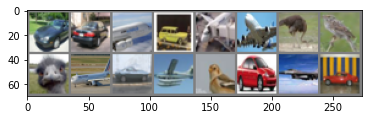

automobile automobile airplane automobile airplane airplane  bird  bird  bird airplane automobile airplane  bird automobile airplane automobile


In [ ]:
_, trainloader, testloader, _, _ = get_loaders()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

net = Net().to(device)

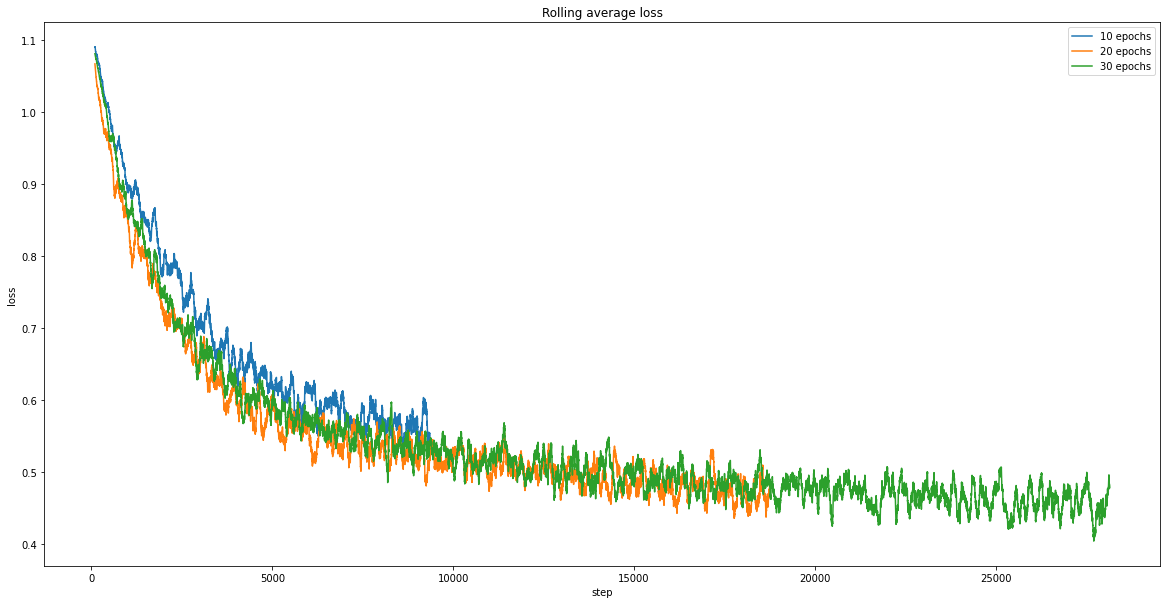

In [ ]:
epochs = [10, 20, 30]

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('step')
ax.set_ylabel('loss')

for epoch_ndx, curr_epochs in enumerate(epochs, 0):
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)
    
    total_step = len(trainloader)
    plt_data[epoch_ndx] = []
    running_loss = 0.0
    for epoch in range(curr_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if device != 'cpu':
              inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            plt_data[epoch_ndx].append(loss.item())

    ax.set_title('Rolling average loss'.format(curr_epochs))
    ax.plot(pd.Series(plt_data[epoch_ndx]).rolling(100).mean(), label='{} epochs'.format(curr_epochs))
    ax.legend(loc='best')

Se observa que el promedio de costo es mejor para 30 epochs, pero con 20 epochs se llega a un resultado no mucho peor en menos tiempo.

### Punto F

Agregar una capa convolucional, una capa de max pooling y una capa lineal de modo que la red siga funcionando. Explicar la elección de dimensiones para que la red sea funcional.

Agregaremos:

* una capa convolucional de 6 canales de entrada y 12 de salida, con un kernel de 3x3 y padding 'same', para mantener el mismo tamaño de imagen que obtuvimos del pooling anterior (14x14).
* otra capa de max pooling de 2x2, que reducirá el tamaño de imagen a 7x7
* una capa lineal con 12 features de entrada y 3 de salida

Se modificó la capa lineal existente para que tome 12 features de entrada y genere 6 features de salida, de manera tal de poder agregar otra capa lineal.

Files already downloaded and verified
Files already downloaded and verified


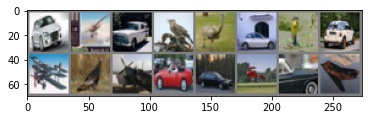

automobile airplane automobile  bird  bird automobile  bird automobile airplane  bird airplane automobile automobile airplane automobile airplane


In [ ]:
_, trainloader, testloader, classes, _ = get_loaders()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 3, padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)     
        self.fc1 = nn.Linear(12 * 7 * 7, 6)
        self.fc2 = nn.Linear(6, 3)

    def forward(self, x):
        x = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(x))))))
        x = torch.flatten(x, 1)
        x = self.fc2(F.relu(self.fc1(x)))
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.8001


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 69 %
Accuracy for class airplane is: 56.3 %
Accuracy for class automobile is: 74.4 %
Accuracy for class bird  is: 79.1 %


Se observa un buen rendimiento de la red respecto de la variante con menos capas.

### Punto G

Reemplazar la red convolucional por un perceptron multicapa. Variar la cantidad de capas y neuronas y comparar los resultados.

Creamos una red de 3 capas, con las siguientes dimensiones:

* 3x32x32 -> 3x16x16 (canales x ancho x alto)
* 3x16x16 -> 3x8x8
* 3x8x8 -> 3

Utilizamos ReLU como función de activación

Files already downloaded and verified
Files already downloaded and verified


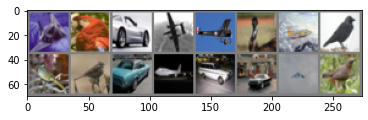

airplane  bird automobile airplane airplane  bird airplane  bird  bird  bird automobile airplane automobile automobile airplane  bird


In [ ]:
_, trainloader, testloader, _, _ = get_loaders()

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3 * 32 * 32, 3 * 16 * 16)
        self.l2 = nn.Linear(3 * 16 * 16, 3 * 8 * 8)
        self.l3 = nn.Linear(3 * 8 * 8, 3)

    def forward(self, x):
        x = self.l1(torch.flatten(x, 1))
        x = self.l2(F.relu(x))
        x = self.l3(F.relu(x))
        return x
    
net = MLP().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, 10, trainloader, True)

Finished Training, last epoch mean loss 0.5990


In [ ]:
calc_accuracy(testloader, classes)

Accuracy of the network on the 10000 test images: 76 %
Accuracy for class airplane is: 72.8 %
Accuracy for class automobile is: 80.2 %
Accuracy for class bird  is: 77.5 %


Se observa una buena performance de la implementación, en valores cercanos a la CNN de múltiples capas.

## Ejercicio 2: Regularización

### Punto A

Implementar dropout y penalidad L2. Explicar ambos conceptos.

Dropout es un método de regularización que consiste en desactivar canales de la capa convolucional durante el proceso de entrenamiento de la red, con una dada probabilidad p según una distribución de Bernoulli. Por ende, en cada paso de entrenamiento la estructura de la red cambia de acuerdo con este criterio de activación.
PyTorch escala los parámetros de salida por *1/1-p* para compensar la desactivación, ya que durante el proceso de testeo la red neuronal se utiliza en forma completa.

Se implementa el dropout en el modelo de la CNN:


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


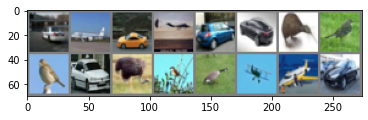

automobile airplane automobile airplane automobile automobile  bird  bird  bird automobile  bird  bird  bird airplane airplane automobile


In [ ]:
_, trainloader, testloader, classes, labels = get_loaders()

Incluimos _p=0_ para tener el caso base sin dropout.

Results for prob. = 0
Finished Training, last epoch mean loss 0.8067
Accuracy for class airplane is: 66.6 %
Accuracy for class automobile is: 61.8 %
Accuracy for class bird  is: 79.1 %
Accuracy of the network on the 10000 test images: 69 % 

Results for prob. = 0.1
Finished Training, last epoch mean loss 0.7931
Accuracy for class airplane is: 61.8 %
Accuracy for class automobile is: 64.6 %
Accuracy for class bird  is: 82.2 %
Accuracy of the network on the 10000 test images: 69 % 

Results for prob. = 0.3
Finished Training, last epoch mean loss 0.8292
Accuracy for class airplane is: 66.3 %
Accuracy for class automobile is: 82.7 %
Accuracy for class bird  is: 53.8 %
Accuracy of the network on the 10000 test images: 67 % 

Results for prob. = 0.5
Finished Training, last epoch mean loss 0.7794
Accuracy for class airplane is: 70.8 %
Accuracy for class automobile is: 70.4 %
Accuracy for class bird  is: 70.9 %
Accuracy of the network on the 10000 test images: 70 % 

Results for prob. = 0.7
Fi

Text(0, 0.5, 'Accuracy')

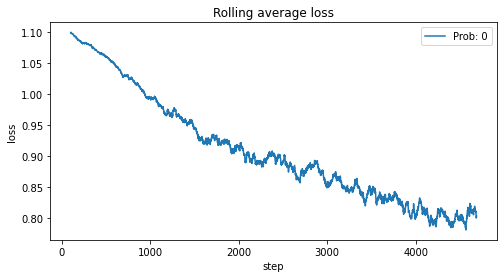

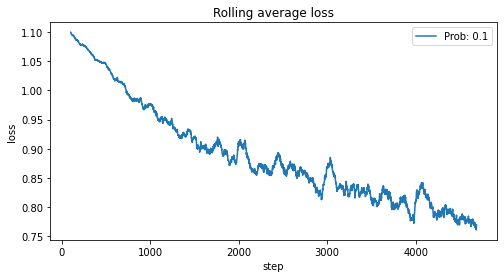

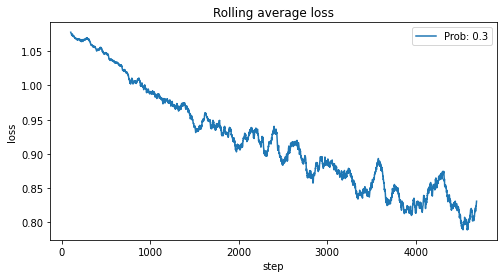

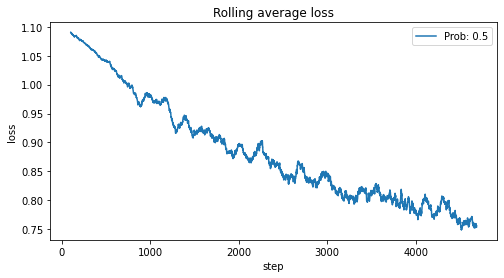

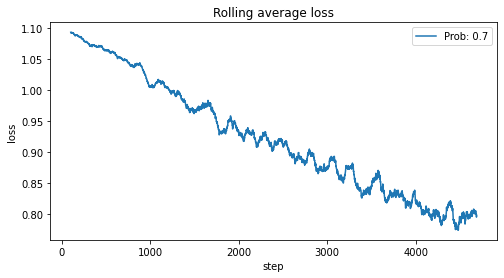

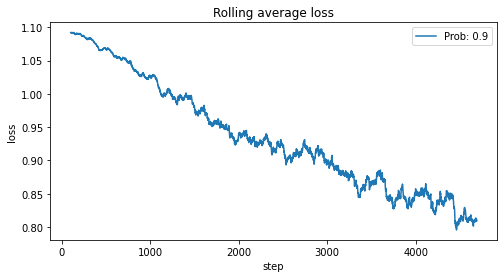

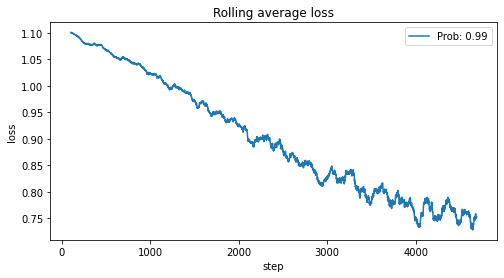

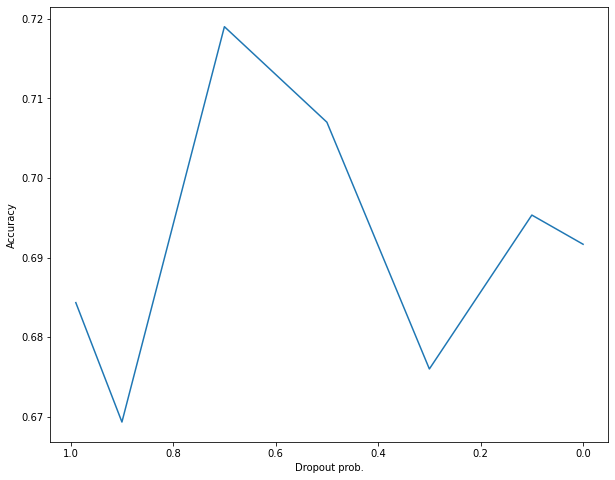

In [ ]:
prob = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
r_tot = []
for p in prob:
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001)

  print('Results for prob. = {}'.format(p))
  net.dropout_hidden = nn.Dropout(p)
  label = ('Prob: {}'.format(p),)
  train(net,5,trainloader,quiet=True,plot=True)
  plt.legend(labels=label, loc='best')
  correct = 0
  total = 0
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  net.eval()  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device != 'cpu':
          images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)
        _, predicted = torch.max(outputs.data, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
  ratio = correct/total
  r_tot.append(ratio)    
  print('Accuracy of the network on the 10000 test images: %d %% \n' % (
    100 * ratio))
fig, ax1 = plt.subplots(figsize=(10,8))  
ax1.plot(prob,r_tot)
ax1.invert_xaxis()
ax1.set_xlabel('Dropout prob.')
ax1.set_ylabel('Accuracy')


Obtuvimos la mejor regularización para el valor _p=0.7_

---



La penalidad L2 es otro método de regularización que consiste en agregar un término adicional a la función pérdida. Este factor fija un parámetro lambda que multiplica a la suma del cuadrado de los pesos del modelo, penalizando la mayor complejidad.

Se implementa regularización L2 al modelo inicial:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(6 * 10 * 10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


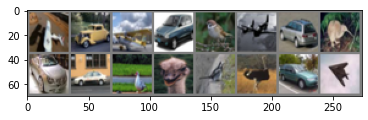

airplane automobile airplane automobile  bird airplane automobile  bird automobile automobile  bird  bird  bird  bird automobile airplane


In [ ]:
_, trainloader, testloader, classes, labels = get_loaders()

Results for lambda = 1e-05
Finished Training, last epoch mean loss 0.6656
Accuracy for class airplane is: 69.6 %
Accuracy for class automobile is: 80.8 %
Accuracy for class bird  is: 76.8 %
Accuracy of the network on the 10000 test images: 75 % 

Results for lambda = 0.0001
Finished Training, last epoch mean loss 0.7364
Accuracy for class airplane is: 68.9 %
Accuracy for class automobile is: 80.4 %
Accuracy for class bird  is: 66.0 %
Accuracy of the network on the 10000 test images: 71 % 

Results for lambda = 0.001
Finished Training, last epoch mean loss 0.7102
Accuracy for class airplane is: 70.7 %
Accuracy for class automobile is: 81.2 %
Accuracy for class bird  is: 71.6 %
Accuracy of the network on the 10000 test images: 74 % 

Results for lambda = 0.01
Finished Training, last epoch mean loss 0.7706
Accuracy for class airplane is: 72.5 %
Accuracy for class automobile is: 69.8 %
Accuracy for class bird  is: 63.9 %
Accuracy of the network on the 10000 test images: 68 % 

Results for 

Text(0, 0.5, 'Accuracy')

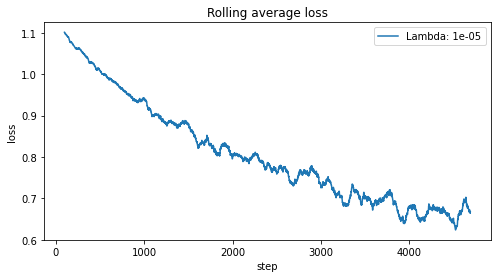

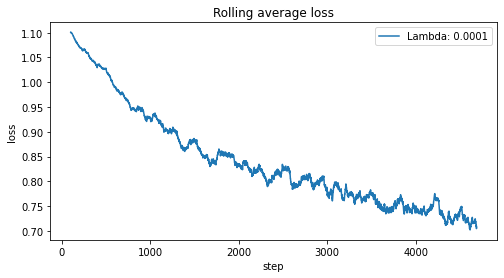

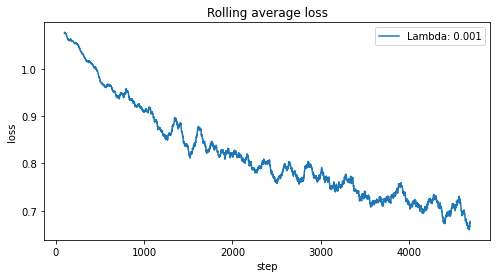

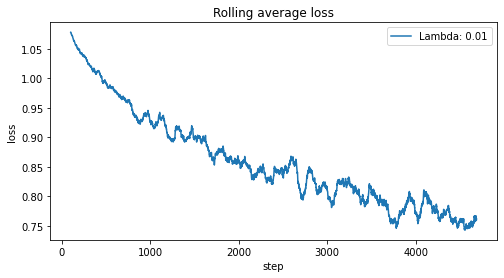

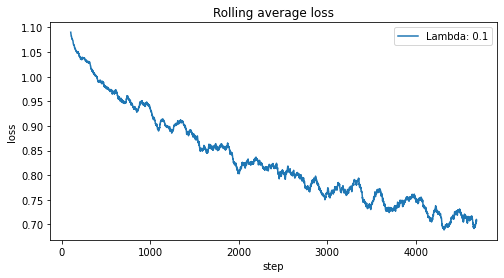

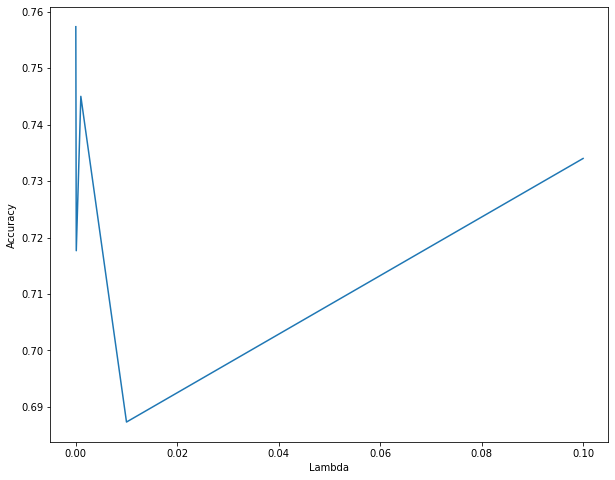

In [ ]:
p_lambda = [1e-5, 1e-4, 1e-3, 0.01, 0.1]
r_tot = []
for l in p_lambda:
  print('Results for lambda = {}'.format(l))
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=l)
  label = ('Lambda: {}'.format(l),)
  train(net,5,trainloader,quiet=True,plot=True)
  plt.legend(labels=label, loc='best')
  correct = 0
  total = 0
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  net.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device != 'cpu':
          images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)
        _, predicted = torch.max(outputs.data, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
  ratio = correct/total
  r_tot.append(ratio)      
  print('Accuracy of the network on the 10000 test images: %d %% \n' % (
    100 * ratio))

fig, ax1 = plt.subplots(figsize=(10,8))  
ax1.plot(p_lambda,r_tot)
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Accuracy')


Con todos los valores de lambda la pérdida fue disminuyendo conforme avanzó el entrenamiento. Para el caso de lambda = 1e-5 se consiguió la mayor precisión.

## Ejercicio 3: Validación

### Punto A

Armar un set de validación separando parte del set de entrenamiento.

Files already downloaded and verified
Files already downloaded and verified


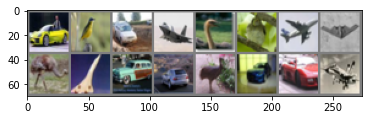

automobile  bird automobile airplane  bird  bird airplane airplane  bird airplane automobile automobile  bird automobile automobile airplane


In [ ]:
trainset, trainloader, testloader, classes, labels = get_loaders()

In [ ]:
batch_size = 16
train_set, val_set = torch.utils.data.random_split(trainset, [int(len(trainset)*0.8),len(trainset)-int(len(trainset)*0.8)])
trainloaderb = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Dataset size: {}'.format(len(trainset)))
print('Train dataset size: {}'.format(len(train_set)))
print('Validation dataset size: {}'.format(len(val_set)))

Dataset size: 15000
Train dataset size: 12000
Validation dataset size: 3000


###Punto B
Implementar *early stopping*. Explicar para qué sirve.

Early stopping es un método de regularización para evitar el overfitting. Se basa en utilizar un set de validación como parámetro para la generalización del error. Se contrasta periódicamente el modelo durante el entrenamiento frente a las muestras de validación, y se detiene el aprendizaje cuando se dejan de obtener descensos sostenidos en la función pérdida para este último.

En nuestra función de entrenamiento, tenemos el siguiente fragmento de código que implementa early stopping:



```
if early_stop:
  # Early stopping
  curr_loss = validate(net)
  loss_ser.append(curr_loss)
  print('Current loss: {:6f}'.format(curr_loss))

  if curr_loss > last_loss:
    best = last_loss
    trigger_times += 1
    print('Trigger times: {}\n'.format(trigger_times))

    if trigger_times >= thres:
      print('Early stopping! Epoch: {}'.format(epoch))
      fig, ax1 = plt.subplots(figsize=(10,5))
      ax1.plot(loss_ser)
      plt.xticks(range(1,epoch+1))              
      ax1.set_ylabel('Loss')
      ax1.set_xlabel('Epoch')
      ax1.set_title('Validation loss')
      ax1.axvline(x=epoch, ls='--')

      return
```

Al finalizar cada epoch, verificamos si la pérdida es superior a la de la epoch anterior. De ser así, incrementamos en 1 el contador del trigger. Si el contador llega a 2 (variable _thres_), detenemos el entrenamiento y mostramos el punto de la evolución de la pérdida en el que nos detuvimos.


In [ ]:
def test(net):

  correct = 0
  total = 0
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  net.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device != 'cpu':
          images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)
        _, predicted = torch.max(outputs.data, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
  ratio = correct/total
  r_tot.append(ratio)      
  print('Accuracy of the network on the 10000 test images: %d %% \n' % (
    100 * ratio))

In [ ]:
def validate(net):
    # Settings
    net.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valloader:
          images, labels = data
          if device != 'cpu':
            images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
       
        loss = criterion(outputs, labels)
        loss_total += loss.item()

    return loss_total / len(valloader)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(6 * 10 * 10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

Epoch [1/20], Step [100/750], Loss: 1.0753, ETA: 0.6952
Epoch [1/20], Step [200/750], Loss: 1.0439, ETA: 0.6966
Epoch [1/20], Step [300/750], Loss: 1.0192, ETA: 0.6933
Epoch [1/20], Step [400/750], Loss: 1.0029, ETA: 0.7194
Epoch [1/20], Step [500/750], Loss: 0.9970, ETA: 0.7758
Epoch [1/20], Step [600/750], Loss: 0.9803, ETA: 0.7131
Epoch [1/20], Step [700/750], Loss: 0.9579, ETA: 0.6778
Current loss: 0.005811
trigger times: 0

Epoch [2/20], Step [100/750], Loss: 0.9256, ETA: 0.7224
Epoch [2/20], Step [200/750], Loss: 0.9013, ETA: 0.7265
Epoch [2/20], Step [300/750], Loss: 0.9101, ETA: 0.6826
Epoch [2/20], Step [400/750], Loss: 0.8670, ETA: 0.7013
Epoch [2/20], Step [500/750], Loss: 0.8579, ETA: 0.7471
Epoch [2/20], Step [600/750], Loss: 0.8698, ETA: 0.6685
Epoch [2/20], Step [700/750], Loss: 0.8529, ETA: 0.7322
Current loss: 0.003906
trigger times: 0

Epoch [3/20], Step [100/750], Loss: 0.8072, ETA: 0.6687
Epoch [3/20], Step [200/750], Loss: 0.8106, ETA: 0.6683
Epoch [3/20], Step [30

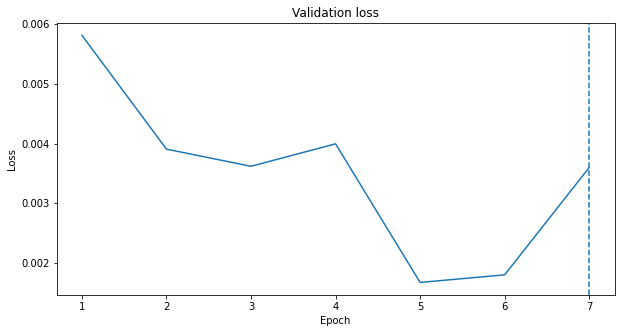

In [ ]:
train(net,20,quiet=False,trainloader=trainloaderb,plot=True, early_stop=True)


Podemos observar que, para este ejemplo, ocurrieron aumentos de la pérdida al validar en las epochs 4, 6 y 7. En la primera, al ocurrir solamente 1 vez, el proceso de entrenamiento continuó. En las 2 últimas, se detuvo porque fueron consecutivas.

En la gráfica puede verse que lo ideal hubiera sido detenerse en la epoch 5, pero si se hubiera adoptado el criterio de 1 trigger para la detención, el proceso se hubiera detenido en la epoch 4, que es peor que la 7.

Este proceso puede ejecutarse varias veces para buscar un criterio más apropiado para cortar según el dataset, siempre que el proceso de entrenamiento no demore mucho tiempo.